In [388]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from pyts.transformation import ShapeletTransform
from pyts.classification import LearningShapelets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import ast

# Reading DF from .csv

In [389]:
daily_stats = pd.read_csv('daily_stats_user.csv', lineterminator='\n', index_col=0)

##### Converting str time series into array

In [390]:
daily_stats['success_ts'] = daily_stats.success_ts.apply(ast.literal_eval)

#### TSs formatting 

In [391]:
X_bot = []
y_bot = []

X_nonbot = []
y_nonbot = []

X_class = []

for row in daily_stats.itertuples():
    if row.bot == 1:
        X_bot.append(row.success_ts)
        y_bot.append(row.bot)
    elif row.bot == 0:
        X_nonbot.append(row.success_ts)
        y_nonbot.append(row.bot)
    else:
        X_class.append(row.success_ts)

X = X_bot + X_nonbot
y = y_bot + y_nonbot


### "Manually extracting" shapelets

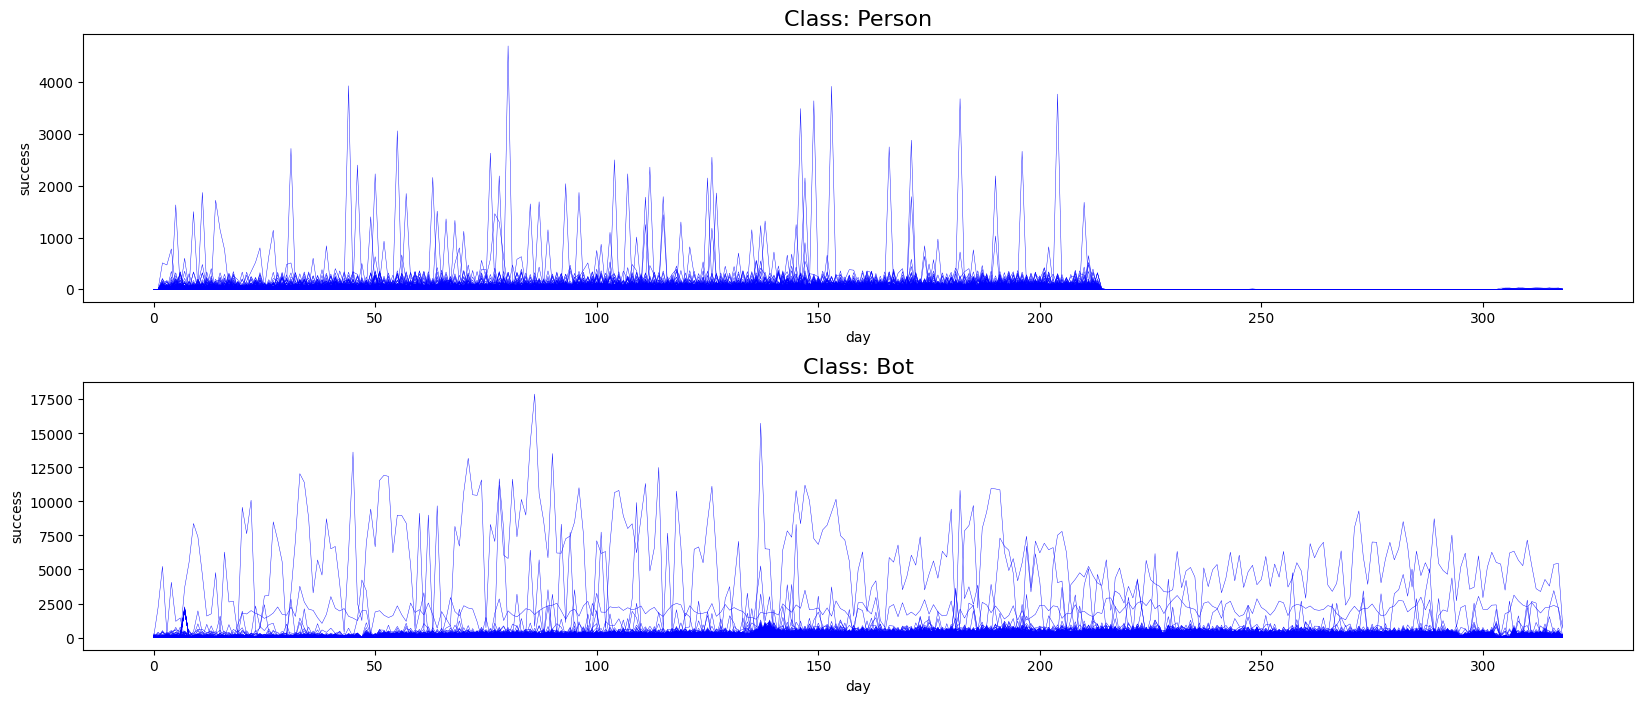

In [435]:
fig, ax =  plt.subplots(2, figsize=(20, 8))

for i, classe in enumerate(['Person', 'Bot']):

    for x in range(0, len(X)):
        if y[x] == i:
            ax[i].plot(X[x], color='blue', linewidth=0.3)
            
    ax[i].set_title('Class: {}'.format(classe), fontsize=16)
    ax[i].set(xlabel='day', ylabel='success')

fig.subplots_adjust(hspace=0.3)
plt.show()

# ShapeletModel creation, training, test and classificaton 

##### Splitting the TSs into traing and test sets

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

##### TSs normalization

In [ ]:

X_train_norm = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X_train)
X_test_norm = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X_test)

X_class_norm = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X_class)

train_norm = []
test_norm = []
class_norm = []

for i in range(len(X_train_norm)):
    train_norm.append(np.array([item for sublist in X_train_norm[i] for item in sublist]))

train_norm = np.array(train_norm)

for i in range(len(X_test_norm)):
    test_norm.append(np.array([item for sublist in X_test_norm[i] for item in sublist]))

test_norm = np.array(test_norm)

for i in range(len(X_class_norm)):
    class_norm.append(np.array([item for sublist in X_class_norm[i] for item in sublist]))

class_norm = np.array(class_norm)


##### Bulding a ShapeletModel

In [397]:
shapelet_sizes = {7: 5, 15: 5, 30:5, 60:5, 90:5, 120:5, 150:5, 180:5, 210:5, 250:5}
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="adam",
                        weight_regularizer=0,
                        max_iter=100,
                        verbose=1,
                        scale=True)
# 000001

##### Fitting the model with the desired TSs

In [ ]:
shp_clf.fit(train_norm, y_train)

##### Saving the model

In [428]:
shp_clf.to_pickle('model74')
shp_clf = ShapeletModel.from_pickle('model74')

### Test accuracy prediction 

In [399]:
predicted_labels = shp_clf.predict(X_test_norm)
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))
predicted_locations = shp_clf.locate(test_norm)

4/4 [==============================] - 1s 70ms/step
Correct classification rate: 0.7406679764243614


#### Classification 

In [ ]:
classification_labels = shp_clf.predict(class_norm)

## Example of matching between shaplets and time series

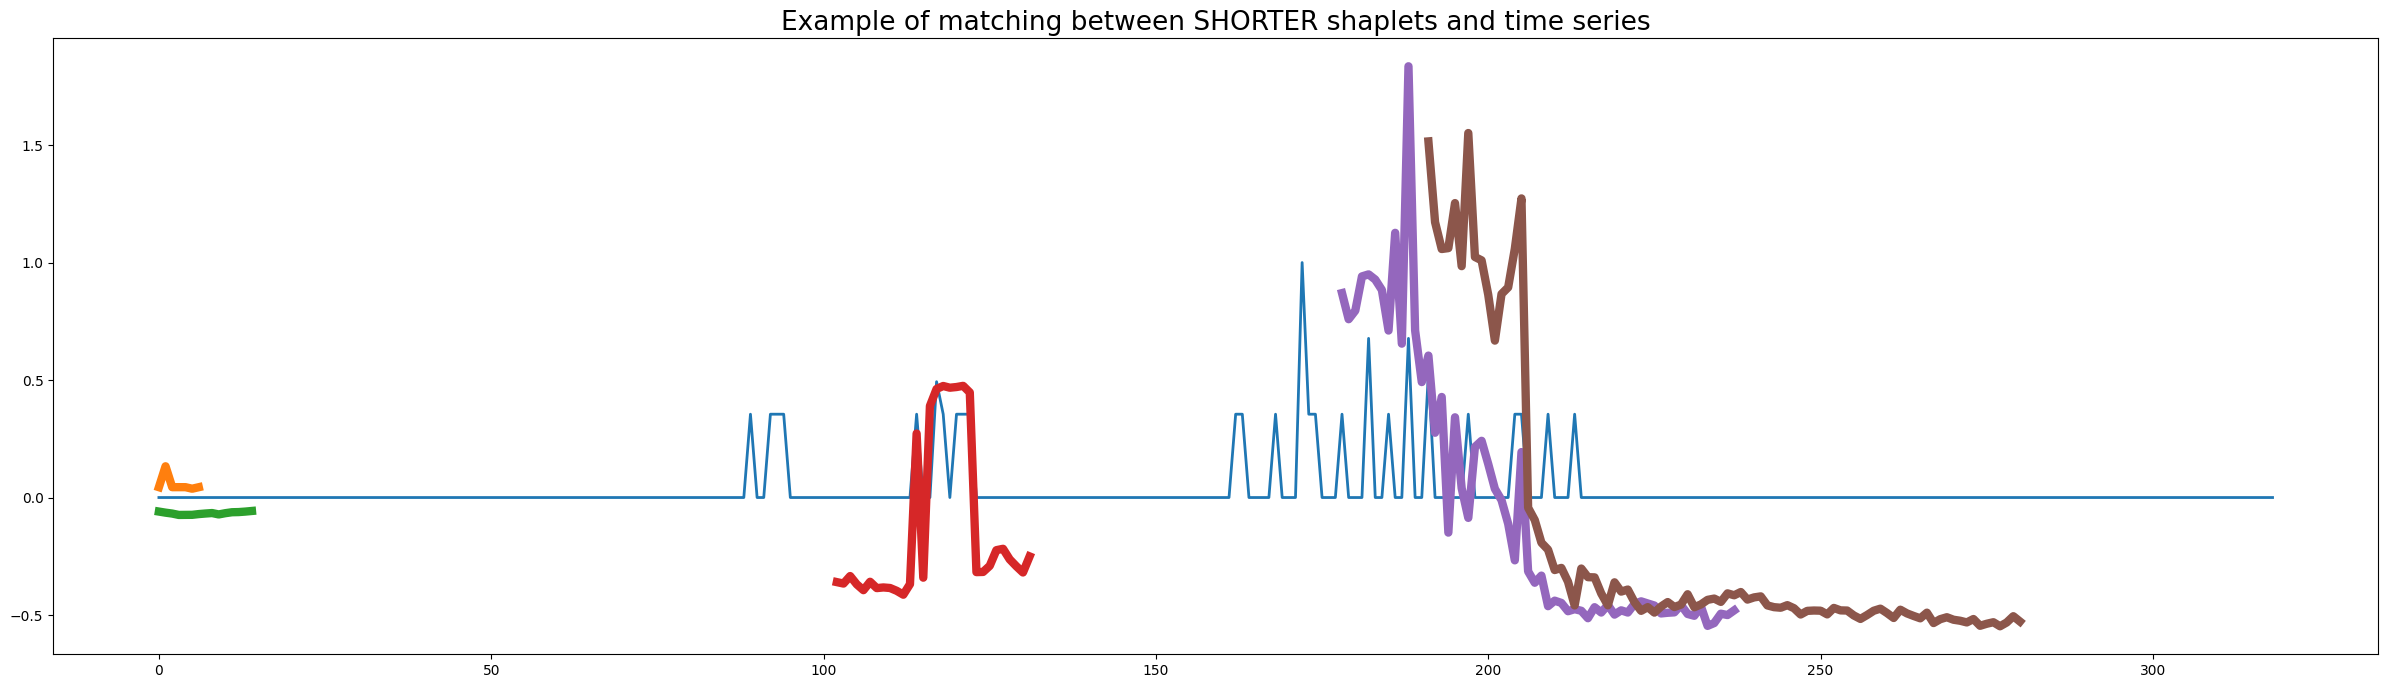

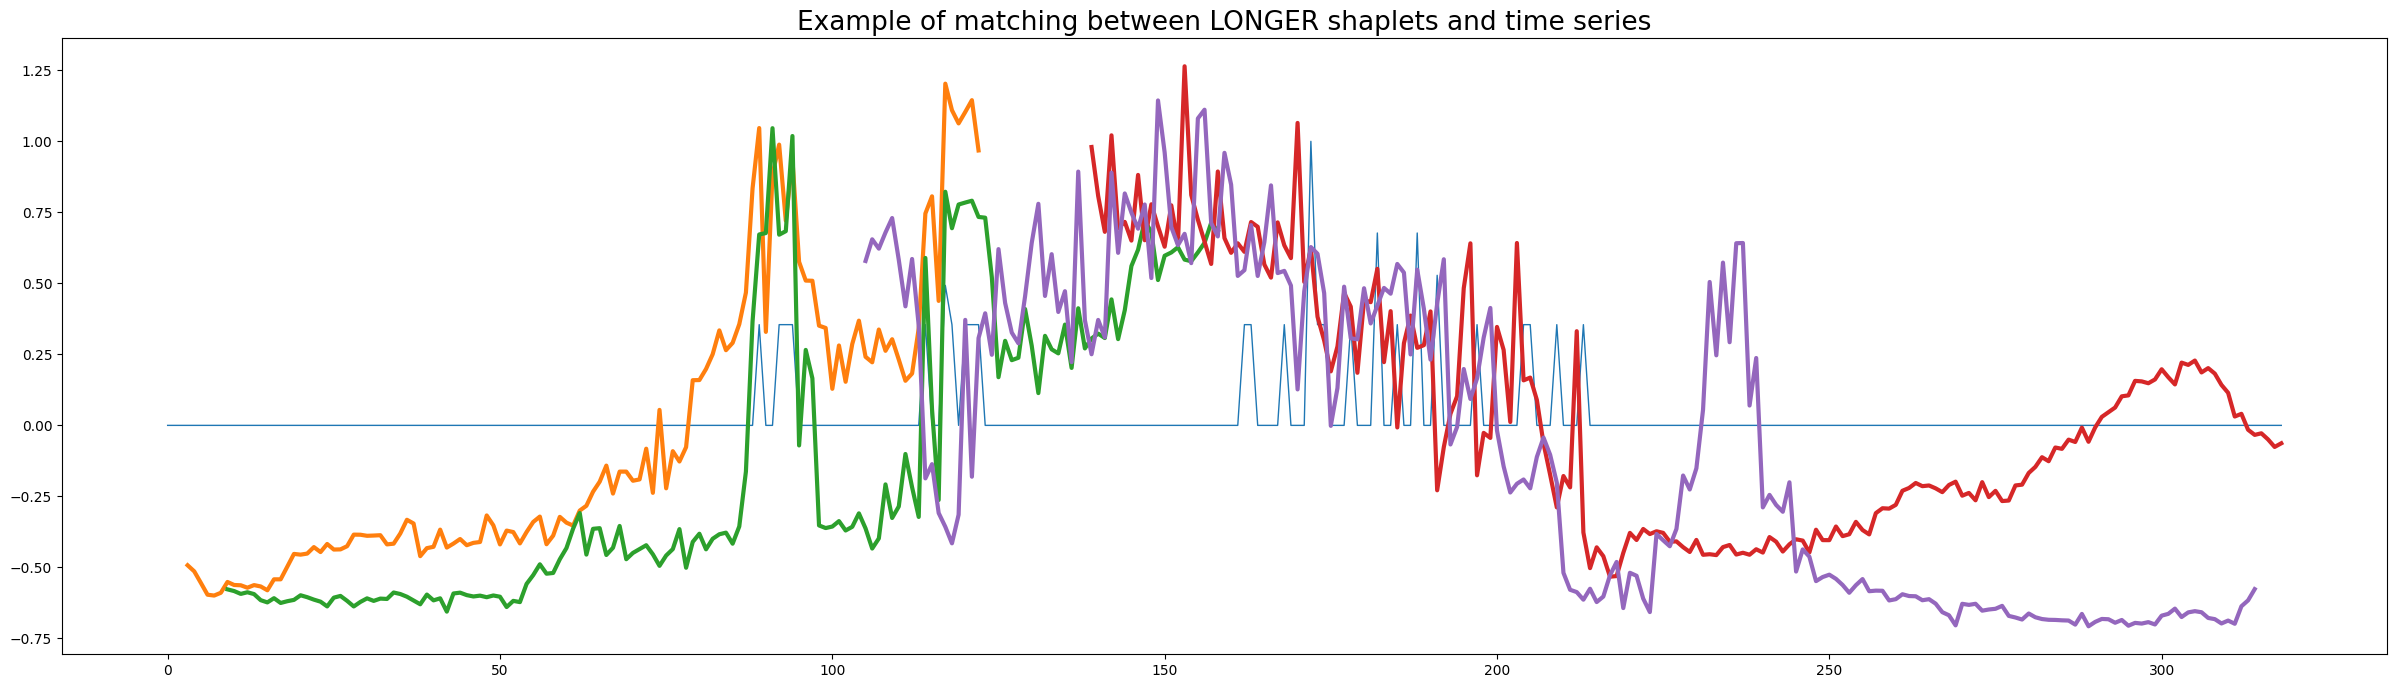

In [431]:
sample_id = 40

plt.figure(figsize=(30,8))
plt.plot(test_norm[sample_id], linewidth=2)

s = shp_clf.shapelets_.tolist()
n_items = [item for item in shapelet_sizes.values()]
index = 0

h = int(len(n_items)/2)

plt.title("Example of matching between SHORTER shaplets and time series", fontsize=19)
for i in range(h): 
    t0 = predicted_locations[sample_id, index]
    plt.plot(np.arange(t0, t0 + len(s[index])), s[index], linewidth=6)
    index = n_items[i] + index
plt.show()


plt.figure(figsize=(30,8))
plt.plot(test_norm[sample_id], linewidth=1)

plt.title("Example of matching between LONGER shaplets and time series", fontsize=19)
for i in range(h+1, len(n_items)): 
    t0 = predicted_locations[sample_id, index]
    plt.plot(np.arange(t0, t0 + len(s[index])), s[index], linewidth=3)
    index = n_items[i] + index
